In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pandas as pd
import numpy as np
sns.set_style("whitegrid")

# read model log file

In [2]:
path = '/home/jeronimo/git/AUT-CNN-TUB/Data/Models/aws_28/model_merge_3CONV_MEMORY_28_b100_s30128_2018-09-21_08-33/model.log'
with open(path) as f:
    f = f.readlines()

# parse log file

In [3]:
steps_entro_train = []
steps_ac_train = []
steps_entro_val = []
steps_ac_val = []
step = []
epoch = []
epoch_entro_test = []
epoch_ac_test = []
epoch_ac_train = []

for line in f:
    if 'step' in line:
        if 'validation cross entropy' in line:
            step.append(int(line.split('step')[1].split(',')[0]))
            steps_entro_val.append(float(line.split('validation cross entropy ')[-1][:-1]))
            
        elif 'validation accuracy' in line:
            steps_ac_val.append(float(line.split('validation accuracy ')[-1][:-1]))
            
        elif 'train accuracy' in line:
            steps_ac_train.append(float(line.split('train accuracy ')[-1][:-1]))
        elif 'train cross entropy' in line:
            steps_entro_train.append(float(line.split('train cross entropy ')[-1][:-1]))
            
            
            
            
    elif 'epoch' in line:
        if 'test accuracy' in line:    
            epoch.append(int(line.split('epoch')[1].split(',')[0]))
            epoch_ac_test.append(float(line.split('test accuracy ')[1][:-1]))
        elif 'training accuracy' in line:
            epoch_ac_train.append(float(line.split('training accuracy ')[1][:-1]))
        elif 'cross' in line:
            epoch_entro_test.append(float(line.split('cross entropy ')[-1][:-1]))

In [4]:
value_list = []
parameter_list = ['ARCHITEKTURE', 'MINIBATCH_SIZE','STEPS', 'PIXEL', 'COLOR', 'CONV',
                  'EPOCH',  'CONV1_DEPTH']

for parameter in parameter_list:
    try:
        value_list.append(re.findall('(?<={}:\s)\w+'.format(parameter), f[0])[0])
    except:
        value_list.append('?')
for line in f:
    
    if 'DROP_KEEP' in line:
        value_list.append(float(re.findall('(?<=DROP_KEEP: )\d+.\d+', line)[0]))
        parameter_list.append('DROP_KEEP')
        
    if 'Model training took'in line:
        value_list.append(float(re.findall('(?<=Model training took, )\d+.\d+', line)[0]) / 60)
        parameter_list.append('RUNTIME')
    if 'test accuracy'in line:
        try:
            value_list.append(round(float(re.findall('(?<=test accuracy: )\d.\d+', line)[0]),5))
        except:
            value_list.append('?')
        parameter_list.append('TEST_ACCURACY')
    if 'LEARNING'in line:
        try:
            value_list.append(re.findall('(?<=LEARNING: )\d.\d+', line)[0])
        except:
            value_list.append('?')
        parameter_list.append('LEARNING')
    
        
value_list.append(f[0].split(' - root -')[0])
parameter_list.append('START_TIME')

df = pd.DataFrame(data=value_list, index=parameter_list, columns=[''])
df.to_csv(path.split('model.log')[0]+'table.csv')

# default graph

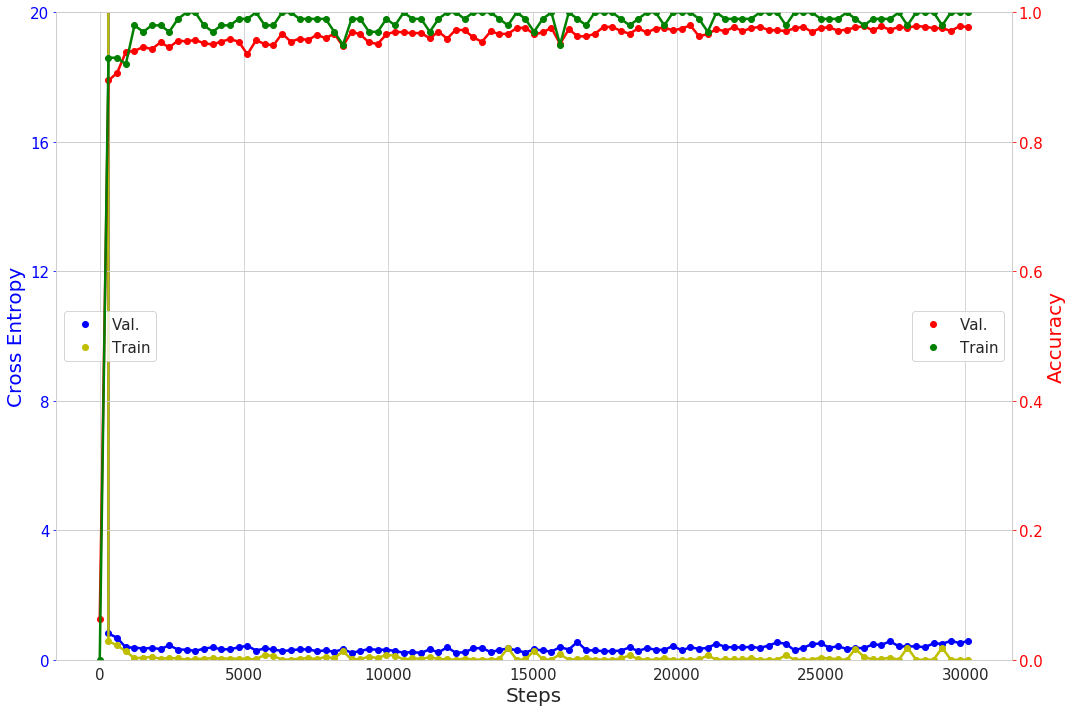

In [5]:

fig, ax1 = plt.subplots(figsize=(15,10))

ax1.plot(step, steps_entro_val, 'bo', label='Val.' )
ax1.plot(step, steps_entro_val, 'b', lw= 2.5)
ax1.plot(step, steps_entro_train, 'yo', label='Train')
ax1.plot(step, steps_entro_train, 'y',  lw= 2.5)
ax1.set_ylim([0,20])
ax1.set_yticks(list(range(0,21, 4)))
#ax1.set_yscale('symlog')
ax1.set_xlabel('Steps').set_fontsize(20)
ax1.tick_params('x', labelsize=15)

ax1.legend(loc=6, fontsize=15)

# Make the y-axis label, ticks and tick labels match the line color.

ax1.set_ylabel('Cross Entropy', color='b').set_fontsize(20)
ax1.tick_params('y', colors='b', labelsize=15)
#ax1.set_yticks([10,5,1,0.5])


ax2 = ax1.twinx()
ax2.set_ylim([0,1])
#ax2.set_yscale('log')
ax2.plot(step, steps_ac_val, 'ro', label='Val.')
ax2.plot(step, steps_ac_val, 'r', lw= 2.5)

ax2.plot(step, steps_ac_train, 'go', label='Train')
ax2.plot(step, steps_ac_train, 'g',  lw= 2.5)
ax2.set_ylabel('Accuracy', color='r').set_fontsize(20)

ax2.tick_params('y', colors='r', labelsize=15)

ax2.legend(loc=7, fontsize=15)
fig.tight_layout()
plt.savefig(path.split('model.log')[0]+'graph')
plt.show()
plt.close()

# zoomed graph, if CNN has high accuracy

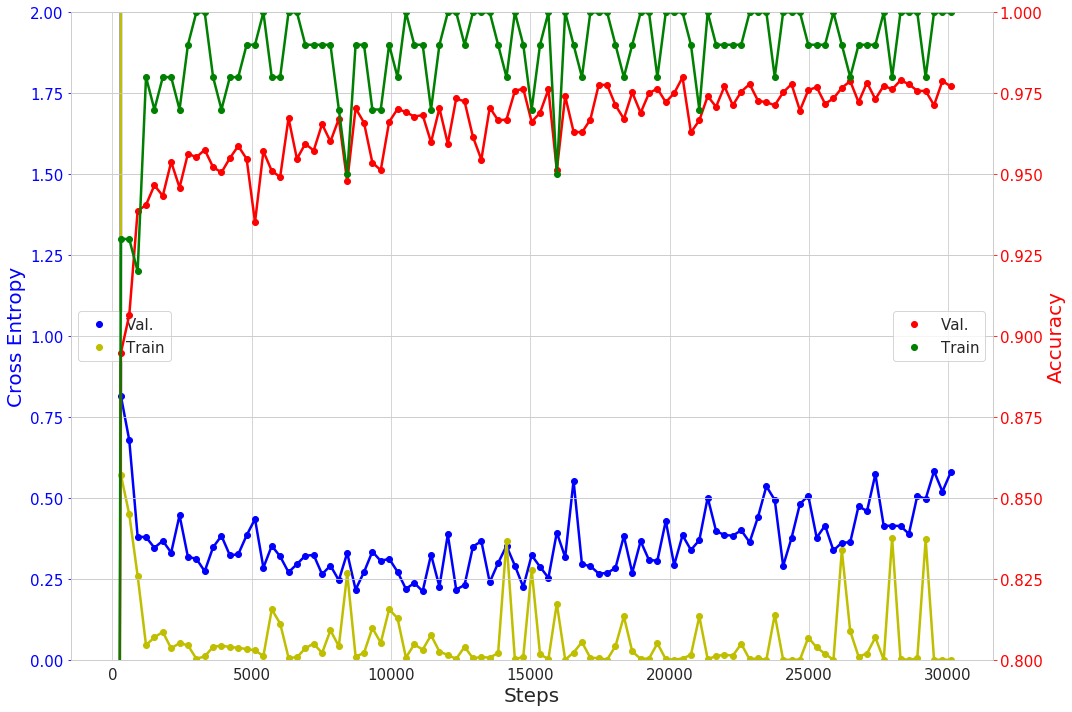

In [6]:

fig, ax1 = plt.subplots(figsize=(15,10))

ax1.plot(step, steps_entro_val, 'bo', label='Val.' )
ax1.plot(step, steps_entro_val, 'b', lw= 2.5)
ax1.plot(step, steps_entro_train, 'yo', label='Train')
ax1.plot(step, steps_entro_train, 'y',  lw= 2.5)
ax1.set_ylim([0,2])
#ax1.set_yticks(list(range(0,21, 4)))
#ax1.set_yscale('log')
ax1.set_xlabel('Steps').set_fontsize(20)
ax1.tick_params('x', labelsize=15)

ax1.legend(loc=6, fontsize=15)

# Make the y-axis label, ticks and tick labels match the line color.

ax1.set_ylabel('Cross Entropy', color='b').set_fontsize(20)
ax1.tick_params('y', colors='b', labelsize=15)
#ax1.set_yticks([10,5,1,0.5])


ax2 = ax1.twinx()
ax2.set_ylim([0.8,1])
#ax2.set_yscale('log')
#ax2.invert_yaxis()
ax2.plot(step,(steps_ac_val), 'ro', label='Val.')
ax2.plot(step,(steps_ac_val), 'r', lw= 2.5)

ax2.plot(step,(steps_ac_train), 'go', label='Train')
ax2.plot(step,(steps_ac_train), 'g',  lw= 2.5)
ax2.set_ylabel('Accuracy', color='r').set_fontsize(20)

ax2.tick_params('y', colors='r', labelsize=15)

ax2.legend(loc=7, fontsize=15)
fig.tight_layout()
plt.savefig(path.split('model.log')[0]+'graph_zoom')
plt.show()

# default graph with hyperparameter

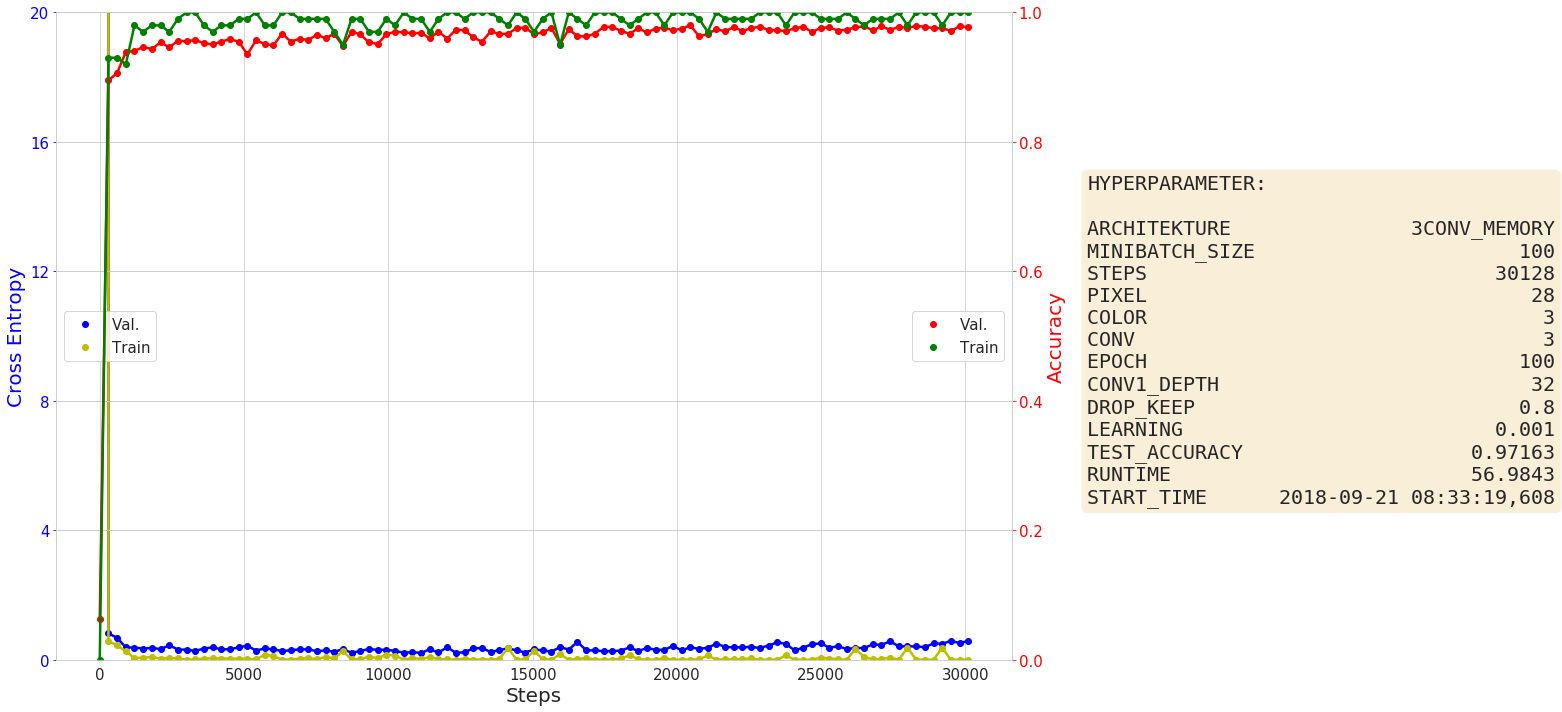

In [7]:
fig, ax1 = plt.subplots(figsize=(15,10))

ax1.plot(step, steps_entro_val, 'bo', label='Val.' )
ax1.plot(step, steps_entro_val, 'b', lw= 2.5)
ax1.plot(step, steps_entro_train, 'yo', label='Train')
ax1.plot(step, steps_entro_train, 'y',  lw= 2.5)
ax1.set_ylim([0,20])
ax1.set_yticks(list(range(0,21, 4)))
#ax1.set_yscale('symlog')
ax1.set_xlabel('Steps').set_fontsize(20)
ax1.tick_params('x', labelsize=15)

ax1.legend(loc=6, fontsize=15)

# Make the y-axis label, ticks and tick labels match the line color.

ax1.set_ylabel('Cross Entropy', color='b').set_fontsize(20)
ax1.tick_params('y', colors='b', labelsize=15)
#ax1.set_yticks([10,5,1,0.5])


ax2 = ax1.twinx()
ax2.set_ylim([0,1])
#ax2.set_yscale('log')
ax2.plot(step, steps_ac_val, 'ro', label='Val.')
ax2.plot(step, steps_ac_val, 'r', lw= 2.5)

ax2.plot(step, steps_ac_train, 'go', label='Train')
ax2.plot(step, steps_ac_train, 'g',  lw= 2.5)
ax2.set_ylabel('Accuracy', color='r').set_fontsize(20)

ax2.tick_params('y', colors='r', labelsize=15)

ax2.legend(loc=7, fontsize=15)
fig.tight_layout()

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
fig.text(1.01,0.75, 'HYPERPARAMETER:\n' + df.to_string(), transform=ax2.transAxes, fontsize=20, family='monospace',
        verticalalignment='top', bbox=props)

plt.savefig(path.split('model.log')[0]+'graph_data', bbox_inches='tight', pad_inches= 0.5)
plt.show()